In [1]:
using Random, PyPlot, Statistics


In [23]:
using JLD

In [2]:
struct Point2D
    x::Int64
    y::Int64
end

struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

import Base.length
function length(lat::SquareLattice)
    return lat.Nx*lat.Ny
end

function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y-1)*lat.Nx + r.x
end

function IndexToPoint(lat::SquareLattice, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,y)
end
    
function NearestNeighbors(lat::SquareLattice, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    yp = mod(r.y, lat.Ny)+1
    xm = mod(r.x-2, lat.Nx)+1
    ym = mod(r.y-2, lat.Ny)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end

function NearestNeighbors(lat::SquareLattice, ind::Int64,direction::Int64)
    @assert direction == 0 || direction == 1
    
    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,2)
    
    if direction == 0    
        xp = mod(r.x, lat.Nx)+1
        xm = mod(r.x-2, lat.Nx)+1
        nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
        nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    end
    
    if direction == 1 
        yp = mod(r.y, lat.Ny)+1
        ym = mod(r.y-2, lat.Ny)+1
        nn[1] =  PointToIndex(lat, Point2D(r.x, ym) )
        nn[2] = PointToIndex(lat, Point2D(r.x, yp) )
    end
    
    return nn
end



NearestNeighbors (generic function with 2 methods)

In [3]:
function ConfigurationEnergy(lat::SquareLattice, c::Vector{Int64},Jx::Float64,Jtau::Float64)
    
    N = length(lat)
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    
    for j in range(1, length = N)
        Xnn = NearestNeighbors(lat, j, 0)
        taunn = NearestNeighbors(lat, j, 1)
        Ec += -Jx*(c[j]-1/2)*sum(c[Xnn].-1/2)
        Ec += -Jtau*(c[j]-1/2)*sum(c[taunn].-1/2)
        
        
    end
    return Ec/2 # in the summation above every bond is included 2 times
    
end

ConfigurationEnergy (generic function with 1 method)

In [4]:
function WolffUpdate!(lat::SquareLattice, c::Vector{Int64},Jx::Float64,Jtau::Float64)

    N = length(lat)
    
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    ind = rand(1:N) # pick a random site
    
   

    cluster = Int64[] # indices of spins in the cluster
    newlyAdded = Int64[] # indices of newly added neighbors
    

    push!(cluster, ind)
    append!(newlyAdded, NearestNeighbors(lat, ind))
    
    
    
    # differently for different directions?
    
    #we want to check if the spin is aligned with the cluste. the probability is measured with respect to J,
    #so we must know if the new spin is connected to its neighbor (and to  the cluster) with Jt or Jx
    newlyAddedDirection = Int64[] # 0 is X 1 is tau
    append!(newlyAddedDirection,[0,0,1,1]) #we now that the first two are x direction
    
    
    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        direction  = pop!(newlyAddedDirection)
        if j in cluster
            continue
        end
        @assert direction == 0 || direction == 1
        J = direction == 0 ? Jx : Jtau #if direction is 0- Jx else Jtau
        if direction == 1
            @assert J == Jtau
        end
        #spin_ind = 2c[ind] - 1
        #spin_j = 2c[j] - 1
        p = 1. - exp(-2*J)
        if c[j]==c[ind] && rand() < p # if si_e and sj_e are unti-aligned  p will be negative
            push!(cluster, j)
            nn = NearestNeighbors(lat, j)
            append!(newlyAdded, nn)
            append!(newlyAddedDirection,[0,0,1,1])
        end
    end

    #flip the cluster!
    c[cluster] = 1 .- c[cluster] # flip the cluster
    
end

WolffUpdate! (generic function with 1 method)

In [5]:
function QMC(lat::SquareLattice,Nsw::Int64,Jx::Float64,Jτ::Float64, saveConfigs = false)
    # Nsw is the number of sweeps to perform
    
    c = rand(0:1, length(lat))
    
    if saveConfigs
        configs = zeros(Float64, Nsw, length(lat))
        configs[1, :] = c
    end
    
    m = zeros(Float64, Nsw) # value of the X magnetization  per site
    m_sq = zeros(Float64, Nsw)
    m_quad = zeros(Float64, Nsw)
    #(r.y-1)*lat.Nx + r.x
    #first: r.x = 1
    #lats: r.x = lat.Nx
    m[1] = 0
    for k in range(1,length = lat.Ny)
        m[1] += abs( mean(2*c[(k-1)*lat.Nx + 1: (k-1)*lat.Nx + lat.Nx] .- 1))/lat.Ny 
        m_sq[1] += abs( mean((2*c[(k-1)*lat.Nx + 1: (k-1)*lat.Nx + lat.Nx] .- 1))^2)/lat.Ny 
        m_quad[1] += abs( mean((2*c[(k-1)*lat.Nx + 1: (k-1)*lat.Nx + lat.Nx] .- 1))^4)/lat.Ny 
    end
    #m[1] = abs(mean(2*c[1:lat.Nx] .- 1))

    En = zeros(Float64, Nsw)
    En[1] = ConfigurationEnergy(lat, c, Jx, Jτ)
    
    for i in range(2, stop=Nsw)
        WolffUpdate!(lat, c,Jx,Jτ)
        
        En[i] = ConfigurationEnergy(lat, c, Jx, Jτ)
        
        if saveConfigs
            configs[i, :] = c
        end
        
        #m[i] = abs(mean(2*c[1:lat.Nx] .- 1))
        m[i]=0
        for k in range(1,length = lat.Ny)
            m[i] += abs( mean(2*c[(k-1)*lat.Nx + 1: (k-1)*lat.Nx + lat.Nx] .- 1))/lat.Ny 
            m_sq[i] += abs( mean((2*c[(k-1)*lat.Nx + 1: (k-1)*lat.Nx + lat.Nx] .- 1))^2)/lat.Ny 
            m_quad[i] += abs( mean((2*c[(k-1)*lat.Nx + 1: (k-1)*lat.Nx + lat.Nx] .- 1))^4)/lat.Ny
        end
        

    end
    
    if saveConfigs
        return m, En, configs
    else
        return m,m_sq,m_quad, En
    end
    
end

QMC (generic function with 2 methods)

# Let's see if it works!

In [6]:
h = 2.0

J = 1.0

T = 0.1J
Deltatau = 0.1/J

Jx = J * Deltatau
Jtau = 1/2*log(coth(Deltatau * h))

Ntau = Int(ceil(1/(T*Deltatau)))
println(Ntau)
println(Jx)
println(Jtau)

100
0.1
0.8113240919944403


In [7]:
lat = SquareLattice(10,Ntau)
Nsw = 10000

m,m_sq,m_quad, En = QMC(lat,Nsw,Jx,Jtau);

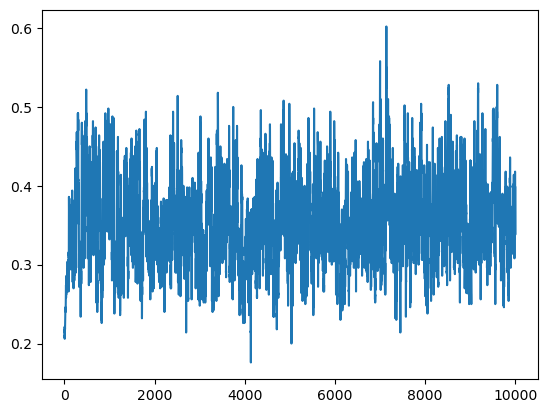

In [8]:
plot(m)
show()


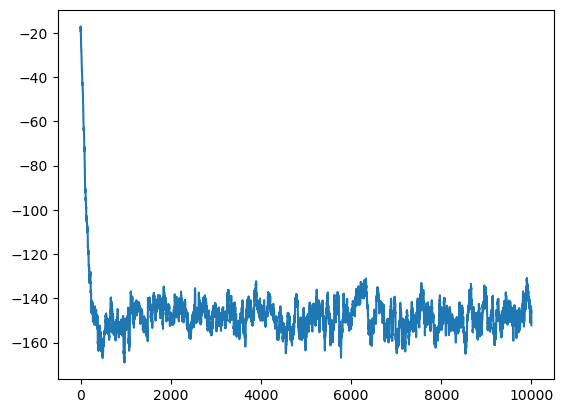

In [9]:
plot(En)
show()

# Let's answer some questions

In [10]:
N_eq = 2000
Nsw = 10000
Lattice_sizes = [8,16,24,32,40]

hs = LinRange(0.1, 2, 20)
J = 1.0
T = 0.1J
Deltatau = 0.1/J
Jx = J * Deltatau
Ntau = Int(ceil(1/(T*Deltatau)))


magnetization = zeros(Float64,length(hs),length(Lattice_sizes))
magnetization_sqrd = zeros(Float64,length(hs),length(Lattice_sizes))
magnetization_quad = zeros(Float64,length(hs),length(Lattice_sizes))
for (k,N) in enumerate(Lattice_sizes)
        lat = SquareLattice(N,Ntau)
        print("N= $N\t")
    Threads.@threads for i in range(1,length=length(hs))
        #println("working on h=$(hs[i]).")
        Jtau = 1/2*log(coth(Deltatau * hs[i]))
        m,m_sq,m_quad, En = QMC(lat,Nsw,Jx,Jtau);
        magnetization[i,k] = mean(m[N_eq:end])
        magnetization_sqrd[i,k] = mean(m_sq[N_eq:end])
        magnetization_quad[i,k] = mean(m_quad[N_eq:end])
    end
end


N= 8	N= 16	N= 24	N= 32	N= 40	

In [26]:
#save("PS3_1.jld", "m", magnetization, "m_sq",magnetization_sqrd,"m_quad",magnetization_quad,"hs",hs,"Lattice_sizes",Lattice_sizes)

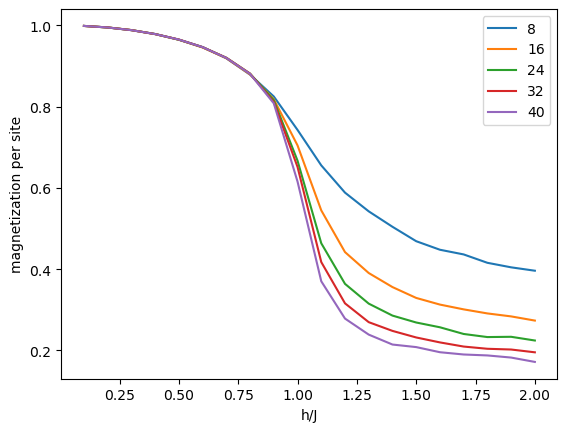

In [27]:
plot(hs,magnetization)
legend(["8","16","24","32","40"])
xlabel("h/J")
ylabel("magnetization per site")
show()

In [28]:
function Binder(m_sq,m_quad)
    return 3/2 * (1- (1/3)*m_quad/m_sq^2)
end


Binder (generic function with 1 method)

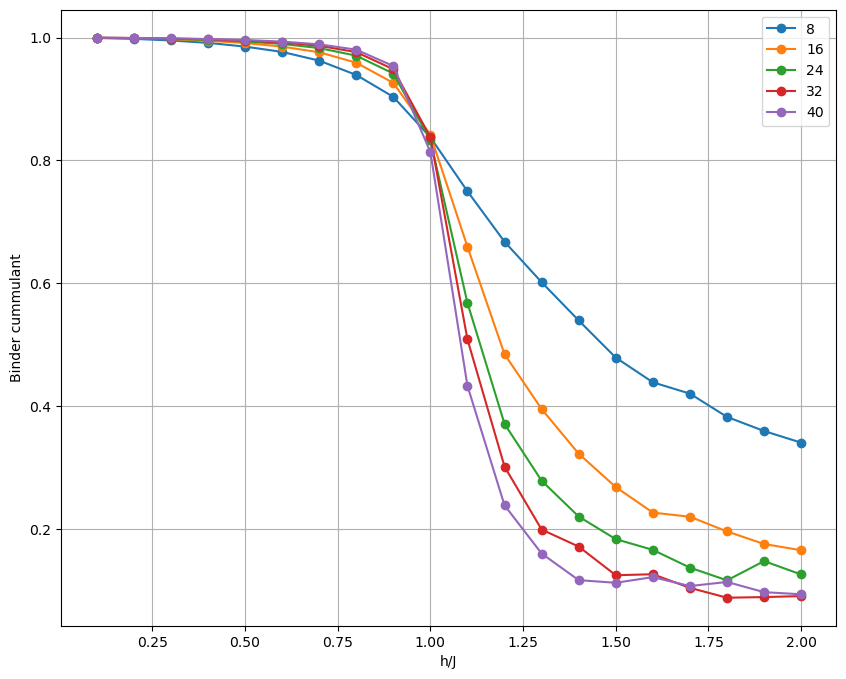

In [29]:
Binder_com = Binder.(magnetization_sqrd,magnetization_quad)
figure(figsize=[10,8])
plot(hs,Binder_com,"-o")
legend(["8","16","24","32","40"])
ylabel("Binder cummulant")
xlabel("h/J")
grid()
show()

# Success! 